<a href="https://colab.research.google.com/github/XueqingWu/Explainable_AI_Local_Explanation/blob/main/Interpretable_ML_Local_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Local Explanation for ResNet34

In [1]:
pip install lime==0.2.0.1

## Import Packages

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

## Load Pretrained ResNet34 Model

In [3]:
# Load the pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Define the image transformation for ResNet input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load an example image
image_path = 'Cat.jpg'  # Ensure the image file exists
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

## Explain the ResNet34 Model with LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

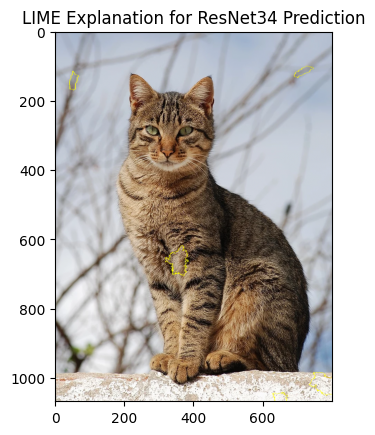

In [5]:
# Prediction function for LIME
def predict_fn(images):
    images = torch.stack([transform(Image.fromarray(img)) for img in images], dim=0)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1).numpy()
    return probs

# Initialize the LIME explainer for images
explainer = lime_image.LimeImageExplainer()

# Explain the instance
explanation = explainer.explain_instance(np.array(image), predict_fn, top_labels=1, hide_color=0, num_samples=1000)

# Show explanation (mark the superpixels used in the explanation)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title('LIME Explanation for ResNet34 Prediction')
plt.show()


## Explaination of the Model

According to the interpretation of LIME, ResNet34 is using the fur of the cat, the color of the ground, and branches to classify the image.

## Process of LIME

1. Select an instance of interest
2. Perturb your dataset and get black box predictions for perturbed
samples
3. Generate a new dataset consisting of perturbed samples (variations
of your data) and the corresponding predictions
4. Train an interpretable model, weighted by the proximity of sampled
instances to the instance of interest
5. Interpret the local model to explain prediction


## LIME Evaluation

### Reason for Choosing LIME
1. LIME can apply local explanation to image data

### Strength of LIME
1. LIME does not take up lots of computation power

### Limitation of LIME
1. Instable explanations--not always conssistent across settings and experiments
2. Can be used to hide bias and can be easily fooled

### Potential Improvement of the Project
1. Tune the parameter of image to see if we get different explanations from LIME (eg: image normalization)
2. Tune how LIME find neighbors to see if that changes the explanation.


## References
LIME model: https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/local_explanations.ipynb#scrollTo=WvkxtQjkPE7r

Image: https://www.google.com/search?q=cat+november&sca_esv=4997d9601951f80e&sca_upv=1&udm=2&biw=1440&bih=778&sxsrf=ADLYWIL4UuAuipwchn46ky0rdZVV78lnpA%3A1727841527713&ei=98T8ZreZK6DV5NoP6Y3NsQ4&ved=0ahUKEwj38PKj5-6IAxWgKlkFHelGM-YQ4dUDCBA&uact=5&oq=cat+november&gs_lp=Egxnd3Mtd2l6LXNlcnAiDGNhdCBub3ZlbWJlcjIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgAQyBRAAGIAEMgUQABiABDIFEAAYgARI0ytQAFiHIXAEeACQAQKYAYoHoAHBG6oBCTguMi4xLjYtM7gBA8gBAPgBAZgCEKAChxXCAgQQIxgnwgIKEAAYgAQYQxiKBcICCBAAGIAEGLEDwgINEAAYgAQYsQMYQxiKBcICEBAAGIAEGLEDGEMYgwEYigXCAgsQABiABBixAxiDAcICBxAAGIAEGArCAgYQABgKGB7CAgQQABgewgIGEAAYBRgewgIIEAAYCBgKGB7CAgYQABgIGB6YAwCSBwoxMi4xLjEuNi0yoAe4UA&sclient=gws-wiz-serp#vhid=ff2ayUEEPZyarM&vssid=mosaic
